In [45]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pprint
pp = pprint.PrettyPrinter(indent=4)
import time

### Importing and Exporing Values from HDF5 file to Txt hits

In [46]:
files = [#"/media/panosetigraph/4TB_SSD/Calipso-Data/20210521/PANOSETI_LICK_2021_05_21_10-37-13.h5"]
        "/media/panosetigraph/4TB_SSD/Calipso-Data/20210529/PANOSETI_LICK_2021_05_29_10-42-10.h5"]
PHData_format = "DATA{0:09d}"
PHData_fields = ["modNum", "quaNum", "pktNum", "pktUTC", "pktNSEC", "tv_sec", "tv_usec"]

def getPHData(files):
    dataFrames = []
    for file_name in files:
        print("extracting " + file_name)
        with h5py.File(file_name, 'r') as f:
            PHData = f["PHData"]["ModulePair_00254_00001"]
            PHData_len = len(PHData)//8
            print(PHData_len)

            for i in range(PHData_len):
                dataset = PHData[PHData_format.format(i)]
                field_dataset = []
                for f in PHData_fields:
                    field_dataset.append(PHData[PHData_format.format(i)+"_"+f])
                
                for j in range(len(dataset)):
                    field_values = []
                    for f in field_dataset:
                        field_values.append(f[j][0][0])
                    if np.count_nonzero(field_values):
                        dataFrames.append([field_values, dataset[j][0]])
                    
        print("finish " + file_name)

    return dataFrames

def getPHDataHits(frames):
    PH_hits = []
    for hit in frames:
        PH_hits.append([hit[0], max(hit[1])])
    return PH_hits

In [47]:
start_time = time.time()
PH_frames = getPHData(files)
PH_hits = getPHDataHits(PH_frames)
print("----%s seconds----" % (time.time()-start_time))

extracting /media/panosetigraph/4TB_SSD/Calipso-Data/20210529/PANOSETI_LICK_2021_05_29_10-42-10.h5
3
finish /media/panosetigraph/4TB_SSD/Calipso-Data/20210529/PANOSETI_LICK_2021_05_29_10-42-10.h5
----14.036152124404907 seconds----


In [48]:
def split_by_module(hits):
    data_by_module = {}
    for h in hits:
        if not h[0][0] in data_by_module:
            data_by_module[h[0][0]] = [h]
        else:
            data_by_module[h[0][0]].append(h)
    return data_by_module

In [49]:
data = split_by_module(PH_hits)

In [50]:
def exportHits(data, directory = "./"):
    for key in data:
        with open(directory + str(key) + ".txt", "a+") as f:
            for field in PHData_fields:
                f.write(str(field)+"|")
            f.write("pulseHeight")
            for hit in data[key]:
                f.write("\n")
                for field in hit[0]:
                    f.write(str(field)+"|")
                f.write(str(hit[1]))

In [51]:
def importHits(data, module, directory = "./"):
    with open(directory + str(module) + ".txt", "r+") as f:
        f.readline()
        if not module in data:
            data[module] = []
        
        line = f.readline()
        while line:
            line_vals = line.strip("\n").split("|")
            for i in range(len(line_vals)):
                line_vals[i] = int(line_vals[i])
            
            data[module].append([line_vals[:-1], line_vals[-1]])
            line = f.readline()

In [203]:
exportHits(data)

In [8]:
print(len(data[1]), len(data[254]))

10394 4372


In [52]:
hit_data = {}
importHits(hit_data, 1)
importHits(hit_data, 254)

In [53]:
print(len(hit_data[1]), len(hit_data[254]))

10394 4372


In [54]:
pp.pprint(hit_data[1][-15:-1])

[   [[1, 0, 37444, 2962993144, 606593328, 1622286153, 269619], 157],
    [[1, 2, 50402, 2960895990, 645620915, 1622286153, 308662], 224],
    [[1, 1, 17902, 2965417976, 648403917, 1622286153, 311435], 138],
    [[1, 3, 51924, 2964434961, 679942331, 1622286153, 342999], 167],
    [[1, 2, 50403, 2960895990, 878738546, 1622286153, 541785], 169],
    [[1, 2, 50404, 2960895990, 932700994, 1622286153, 595745], 187],
    [[1, 1, 17903, 2965417976, 80473512, 1622286153, 743509], 163],
    [[1, 3, 51925, 2964434960, 123727968, 1622286153, 786793], 192],
    [[1, 2, 50405, 2960895990, 234183872, 1622286153, 897226], 153],
    [[1, 2, 50406, 2960895990, 347706122, 1622286154, 10751], 223],
    [[1, 1, 17904, 2965417976, 403704364, 1622286154, 66745], 177],
    [[1, 1, 17905, 2965417976, 418790453, 1622286154, 81827], 132],
    [[1, 2, 50407, 2960895990, 502077469, 1622286154, 165128], 188],
    [[1, 2, 50408, 2960895990, 749280176, 1622286154, 412324], 205]]


### Graphing Pulse Height Based on Time Interval

In [55]:
import calendar
import scipy.stats as ss
import scipy as sci
import math

In [56]:
starting_time = "2021-05-29 10:52:50"#"2021-05-21 10:44:00"
time_interval = 20 #in seconds
data_dic = hit_data
time_index = 5
NSEC_index = 4

origin_time = calendar.timegm(time.strptime(starting_time, "%Y-%m-%d %H:%M:%S"))
end_time = origin_time + time_interval
print("Interval ", origin_time, " to ", end_time)

Interval  1622285570  to  1622285590


In [57]:
hits_in_interval = {}
for key in data_dic:
    hits_in_interval[key] = []
    for hit in data_dic[key]:
        if hit[0][time_index] >= origin_time and hit[0][time_index] < end_time:
            hits_in_interval[key].append(hit)

In [58]:
print(len(hits_in_interval[1]), len(hits_in_interval[254]))

448 367


In [59]:
pp.pprint(hits_in_interval[1][-15:])

[   [[1, 2, 48402, 2961289211, 474783583, 1622285588, 135282], 173],
    [[1, 2, 48403, 2961289211, 759874550, 1622285588, 420376], 160],
    [[1, 1, 16700, 2965549052, 793558757, 1622285588, 454062], 153],
    [[1, 2, 48404, 2961289211, 824379939, 1622285588, 484885], 200],
    [[1, 2, 48405, 2961289211, 853656679, 1622285588, 514164], 163],
    [[1, 3, 51316, 2964434957, 413208354, 1622285589, 73727], 139],
    [[1, 0, 36798, 2962993144, 663789305, 1622285589, 324280], 161],
    [[1, 1, 16701, 2965549052, 671957436, 1622285589, 332452], 129],
    [[1, 1, 16702, 2965549052, 684300211, 1622285589, 344799], 166],
    [[1, 2, 48406, 2961289211, 706740262, 1622285589, 367245], 176],
    [[1, 1, 16703, 2965549052, 796687145, 1622285589, 457184], 149],
    [[1, 1, 16704, 2965549052, 840354953, 1622285589, 500856], 208],
    [[1, 3, 51317, 2964434957, 888200443, 1622285589, 548721], 155],
    [[1, 1, 16705, 2965549052, 911968150, 1622285589, 572470], 116],
    [[1, 2, 48407, 2961289211, 1535

In [60]:
graph_points = {}
for key in hits_in_interval:
    graph_points[key] = []
    for hit in hits_in_interval[key]:
        graph_points[key].append([int((hit[0][time_index]-origin_time)*1e9) + hit[0][NSEC_index], hit[1]])

In [61]:
highest_PH = {}
for key in graph_points:
    pulse_heights = np.array(graph_points[key])[:,1]
    highest_PH[key] = np.argmax(pulse_heights)
print(highest_PH)

{1: 143, 254: 162}


In [62]:
threshold = 1000

def gaussian(x, l, s):
    return ss.norm.pdf(x, loc=l, scale=s)

data_fit = {}
thresh_removed = {}
for key in graph_points:
    thresh_removed[key] = []
    for hit in graph_points[key]:
        if hit[1] > threshold:
            thresh_removed[key].append(hit)

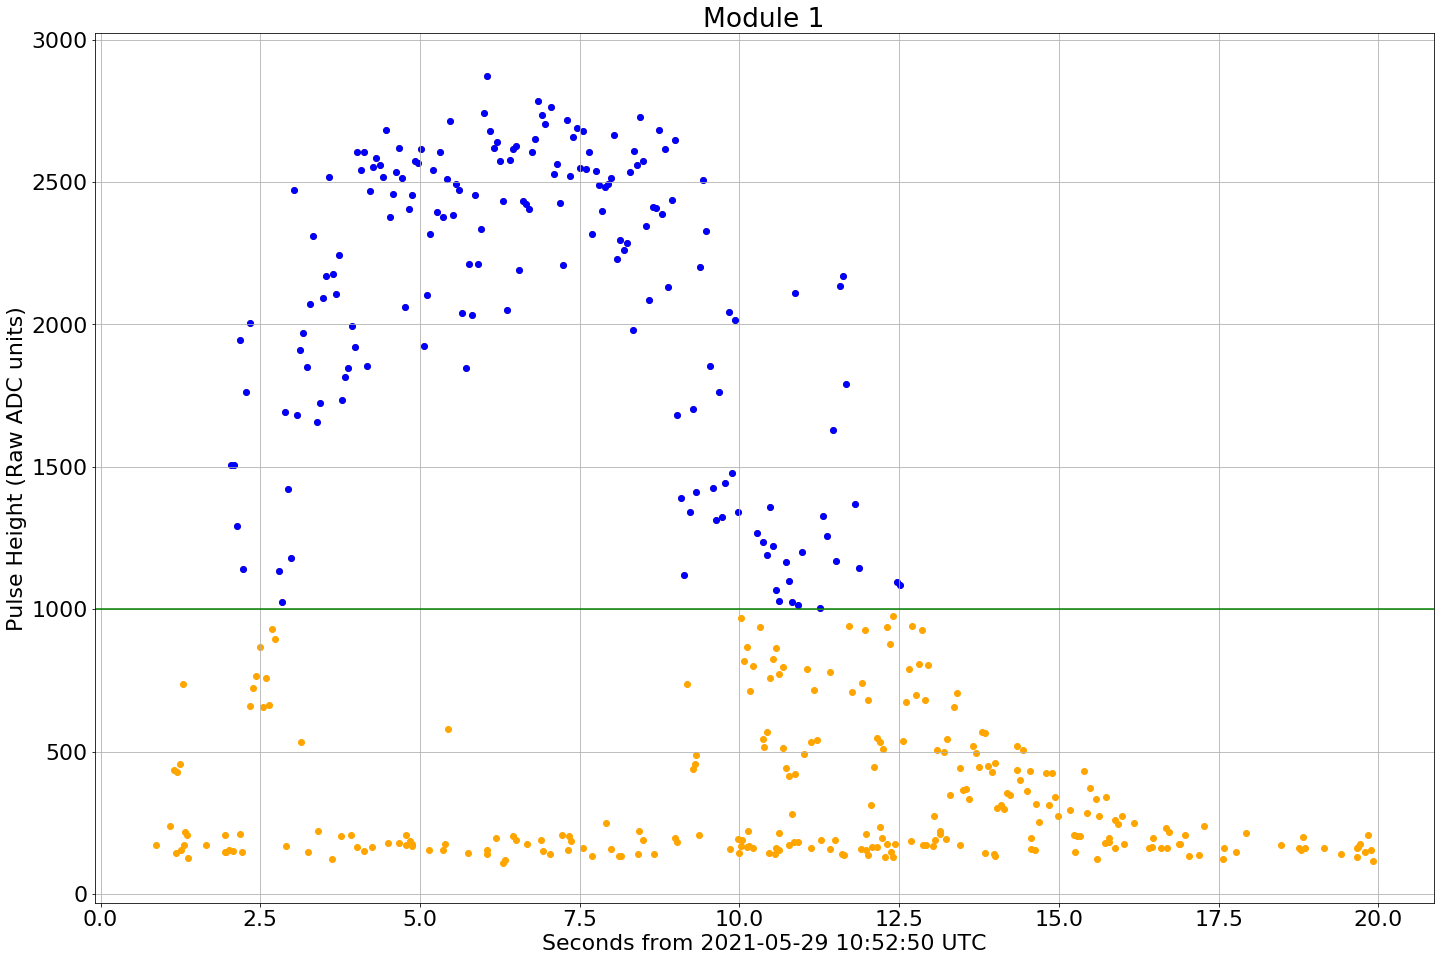

Peak at  Sat May 29 10:52:56 2021 at Nanosecond  52948095


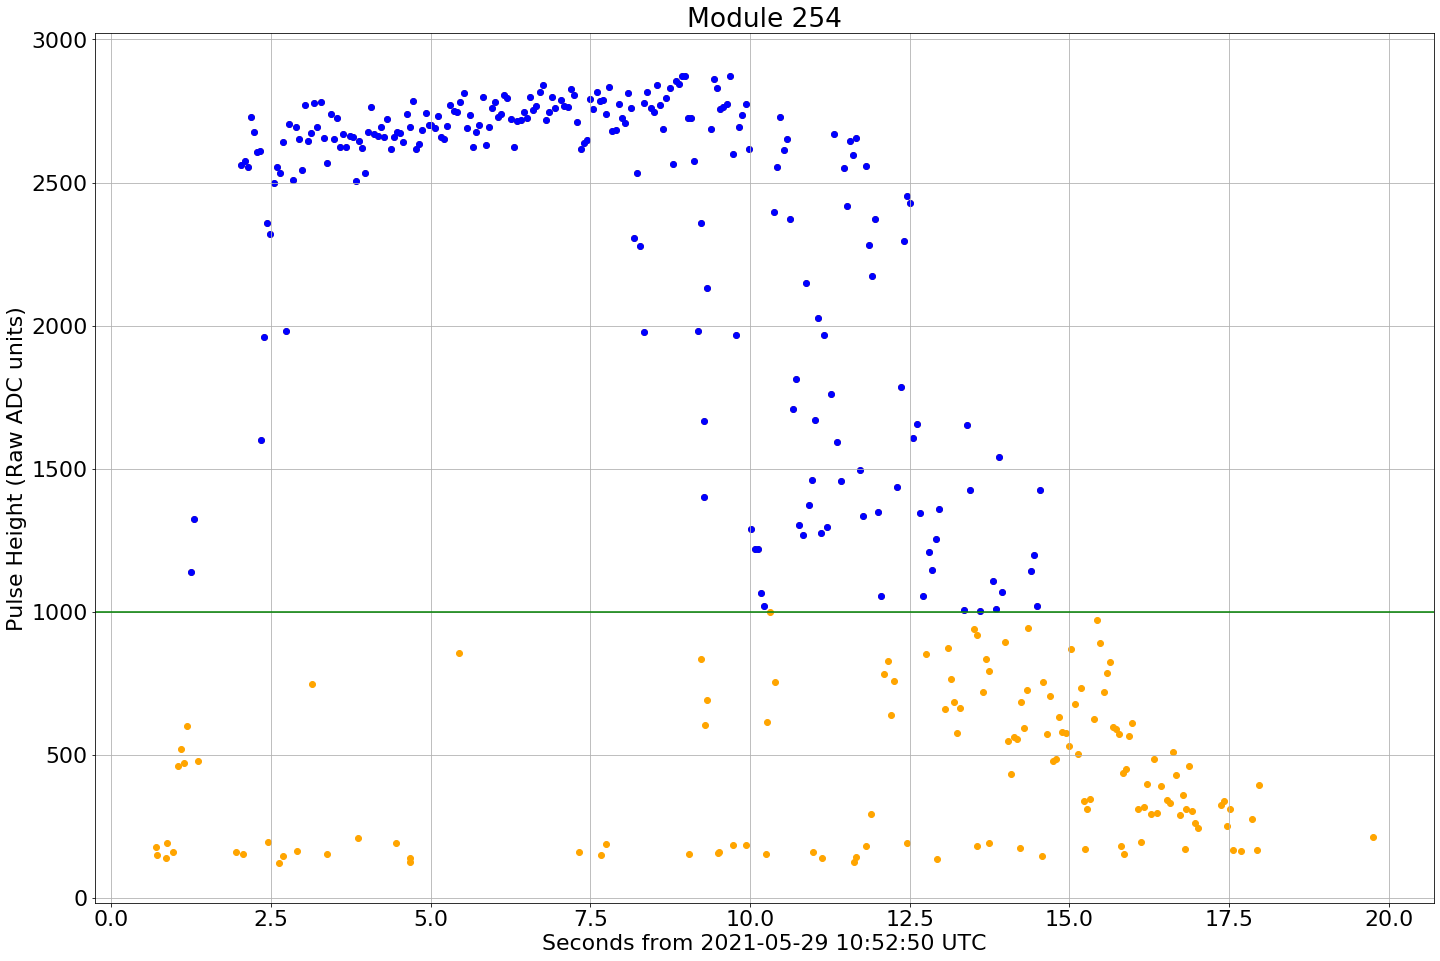

Peak at  Sat May 29 10:52:58 2021 at Nanosecond  987336379


In [63]:
plt.rcParams.update({'font.size': 22})
for key in graph_points:
    fig =plt.figure(figsize=(24,16))
    plt.ylabel("Pulse Height (Raw ADC units)")
    #plt.ylabel("Pulses above " + str(threshold) + " ADC units")
    plt.xlabel("Seconds from " + starting_time + " UTC")
    plt.title("Module "+ str(key))
    plt.scatter(np.array(graph_points[key])[:,0]/1e9, np.array(graph_points[key])[:,1], color="orange")
    #plt.ylim(0,1e5)
    plt.scatter(np.array(thresh_removed[key])[:,0]/1e9, np.array(thresh_removed[key])[:,1], color="blue")
    #plt.axvline(x=graph_points[key][highest_PH[key]][0]/1e9, color="red")
    plt.axhline(y=threshold, color="green")
    
    plt.grid()
    plt.show()
    fig.savefig(str(key) + "_peak_graph.png")
    highest_hit = hits_in_interval[key][highest_PH[key]]
    print("Peak at " , time.asctime(time.gmtime(highest_hit[0][time_index])), "at Nanosecond ", highest_hit[0][NSEC_index])
    #print("Threshold set at ", threshold)

### Create Images from data graph

In [64]:
import os
import glob

In [65]:
data_graphed = thresh_removed
file_hits = {}
for key in data_graphed:
    file_hits[key] = []
    index = 0
    for hit in data_graphed[key]:
        secs = hit[0]//1e9 + origin_time
        nsecs = hit[0]%1e9
        while index < len(hits_in_interval[key]):
            curr_hit = hits_in_interval[key][index]
            if (curr_hit[0][time_index] == secs 
            and curr_hit[0][NSEC_index] == nsecs 
            and curr_hit[1] == hit[1]):
                file_hits[key].append(curr_hit)
                break
            index += 1

In [66]:
print(len(file_hits[1]), len(file_hits[254]))
print(len(data_graphed[1]), len(data_graphed[254]))

177 230
177 230


In [67]:
def header_equals(a, b):
    for i, j in zip(a[0],b[0]):
        if not i == j:
            return False
    return True

file_frames = {}
for key in file_hits:
    file_frames[key] = []
    for hit in file_hits[key]:
        index = 0
        while index < len(PH_frames):
            if header_equals(PH_frames[index], hit):
                file_frames[key].append(PH_frames[index])
                break
            index += 1
    print(index)

8206
8307


In [68]:
print(len(file_frames[1]), len(file_frames[254]))

177 230


In [69]:
#exportHits(file_hits)

/home/panosetigraph/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


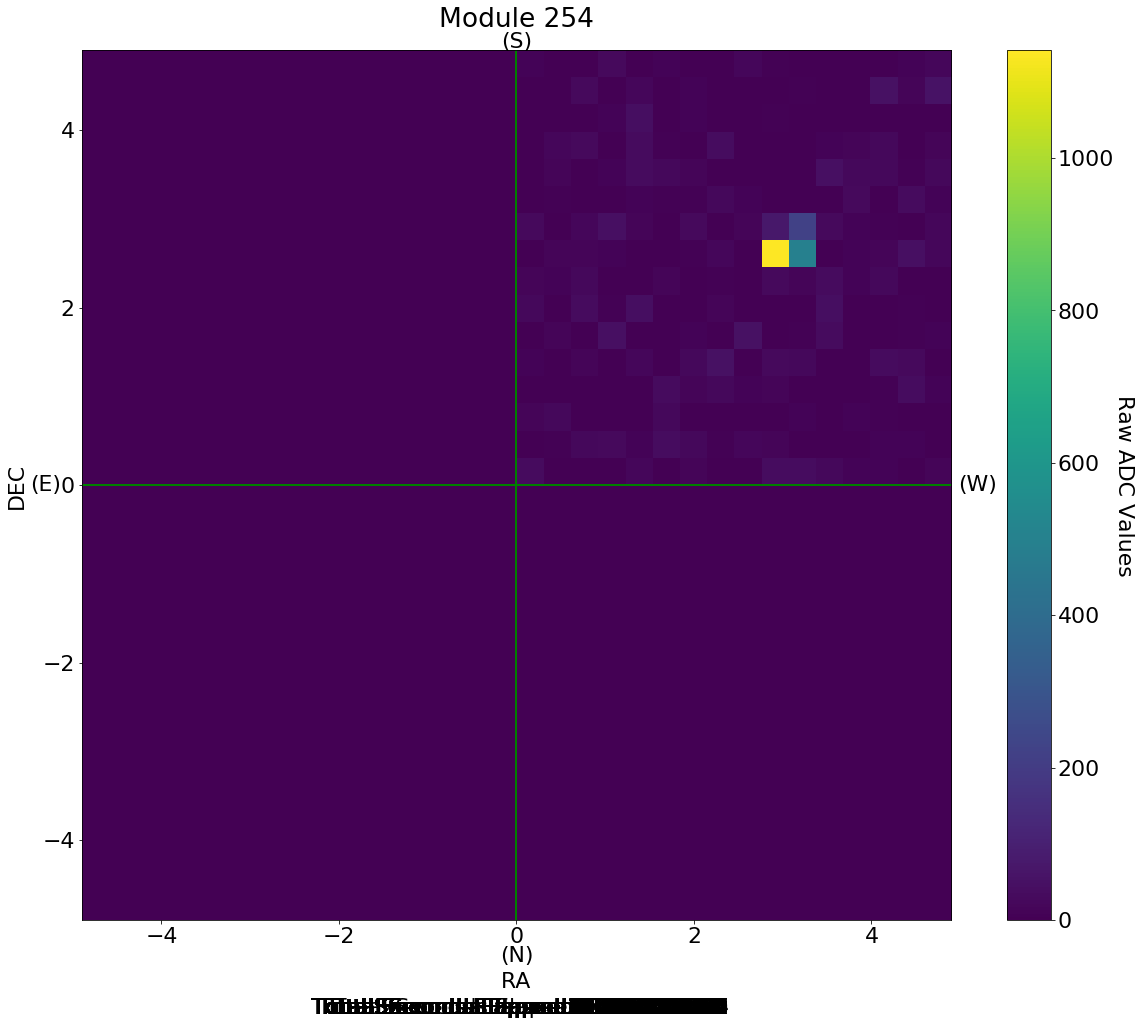

In [70]:
from matplotlib import animation
fig = plt.figure(figsize=(20,16))
ax = fig.gca()
ax.title.set_position([.5, 1.02])
fig.show()

qua_index = 1
rotateNum = [3, 1, 2, 0]
transFlip = [0, 1, 1, 0]
lrFlip = [1, 0, 0, 1]

graph_extent = [-4.9, 4.9, -4.9, 4.9]

firstTime = True
images = []
plotted_images = []
secs_elapsed = 0
prev_NSEC = 0

module_analysed = 254

for hit in np.array(file_frames[module_analysed]):
    img = hit[1].reshape((16,16))
    
    quaNum = hit[0][qua_index]
    if transFlip[quaNum % 4]:
        img = img.T
    img = np.rot90(img, rotateNum[quaNum % 4])
    img = np.flipud(img)
    if lrFlip[quaNum % 4]:
        img = np.fliplr(img)
    if quaNum == 0:
        module = np.append(np.zeros((16,16)), img, axis=0)
        module = np.append(np.zeros((32,16)), module, axis=1)
    elif quaNum == 1:
        module = np.append(np.zeros((16,16)), img, axis=0)
        module = np.append(module, np.zeros((32,16)), axis=1)
    elif quaNum == 2:
        module = np.append(img, np.zeros((16,16)), axis=0)
        module = np.append(module, np.zeros((32,16)), axis=1)
    elif quaNum == 3:
        module = np.append(img, np.zeros((16,16)), axis=0)
        module = np.append(np.zeros((32,16)), module, axis=1)
        
    if hit[0][NSEC_index] < prev_NSEC:
        secs_elapsed += 1
        
    prev_NSEC = hit[0][NSEC_index]
                    
    images.append([hit[0][NSEC_index] + int(secs_elapsed*1e9), module])
    
    #Adding black frames
    #images.append([0, np.zeros((32,32))])
    
                    
    plt.axvline(x=0, color="green")
    plt.axhline(y=0, color="green")
    plt.title("Module " + str(module_analysed)) #+ time.asctime(time.gmtime(origin_time)) +
                 #" Total Seconds Elapsed " + str((hit[0][NSEC_index] + int(secs_elapsed*1e9))/1e9))
    
    ttl = plt.text(0,-6," Total Seconds Elapsed " + str((hit[0][NSEC_index] + int(secs_elapsed*1e9))/1e9), horizontalalignment='center', verticalalignment='bottom')
    plotted_images.append([plt.imshow(module, extent=graph_extent, animated=True), ttl])
    
    if firstTime:
        cbar = plt.colorbar()
        #cbar.ax.set_title("Raw ADC Values")
        cbar.ax.set_ylabel("Raw ADC Values", rotation=270, labelpad=20)
        plt.text(0,-5.3, "(N)", horizontalalignment='center', verticalalignment='center')
        plt.text(5.2,0, "(W)", horizontalalignment='center', verticalalignment='center')
        plt.text(0,5, "(S)", horizontalalignment='center', verticalalignment='center')
        plt.text(-5.3,0, "(E)", horizontalalignment='center', verticalalignment='center')
        plt.xlabel("RA", labelpad=25)
        plt.ylabel("DEC", labelpad=15)
        firstTime = False
    
    #for i in range(4):
    #    plotted_images.append([plt.imshow(np.zeros((32,32)), extent=graph_extent, animated=True), ttl])
    
    

def animate(index):
    plt.axvline(x=0, color="green")
    plt.axhline(y=0, color="green")
    #print(index)
    plt.imshow(images[index][1], extent=graph_extent)

## GIF creator

In [169]:
ani = animation.ArtistAnimation(fig, plotted_images, interval=50, blit=False, repeat_delay=1)#, blit=True, repeat_delay=1)
#ani = animation.FuncAnimation(fig, animate, frames=len(images), interval=38, repeat_delay=1)
ani.save(str(module_analysed) + '_movie.gif', writer="pillow")

## MP4 creator

In [ ]:
FFwriter = animation.FFMpegWriter(fps=20)
ani = animation.FuncAnimation(fig, animate, frames=len(images))
ani.save(str(module_analysed) + '_sec.mp4', writer=FFwriter)

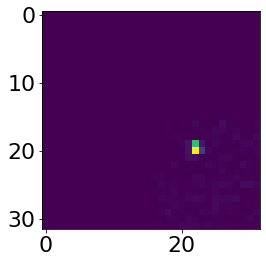

In [28]:
plt.imshow(images[121][1])

In [71]:
image_times = np.array(images)[:,0]

In [82]:
test = np.array(image_dt)*1e-6
print(type(test[0]))

<class 'numpy.float64'>


In [75]:
image_dt = []
for i in range(len(image_times)-1):
    image_dt.append(image_times[i+1] - image_times[i])

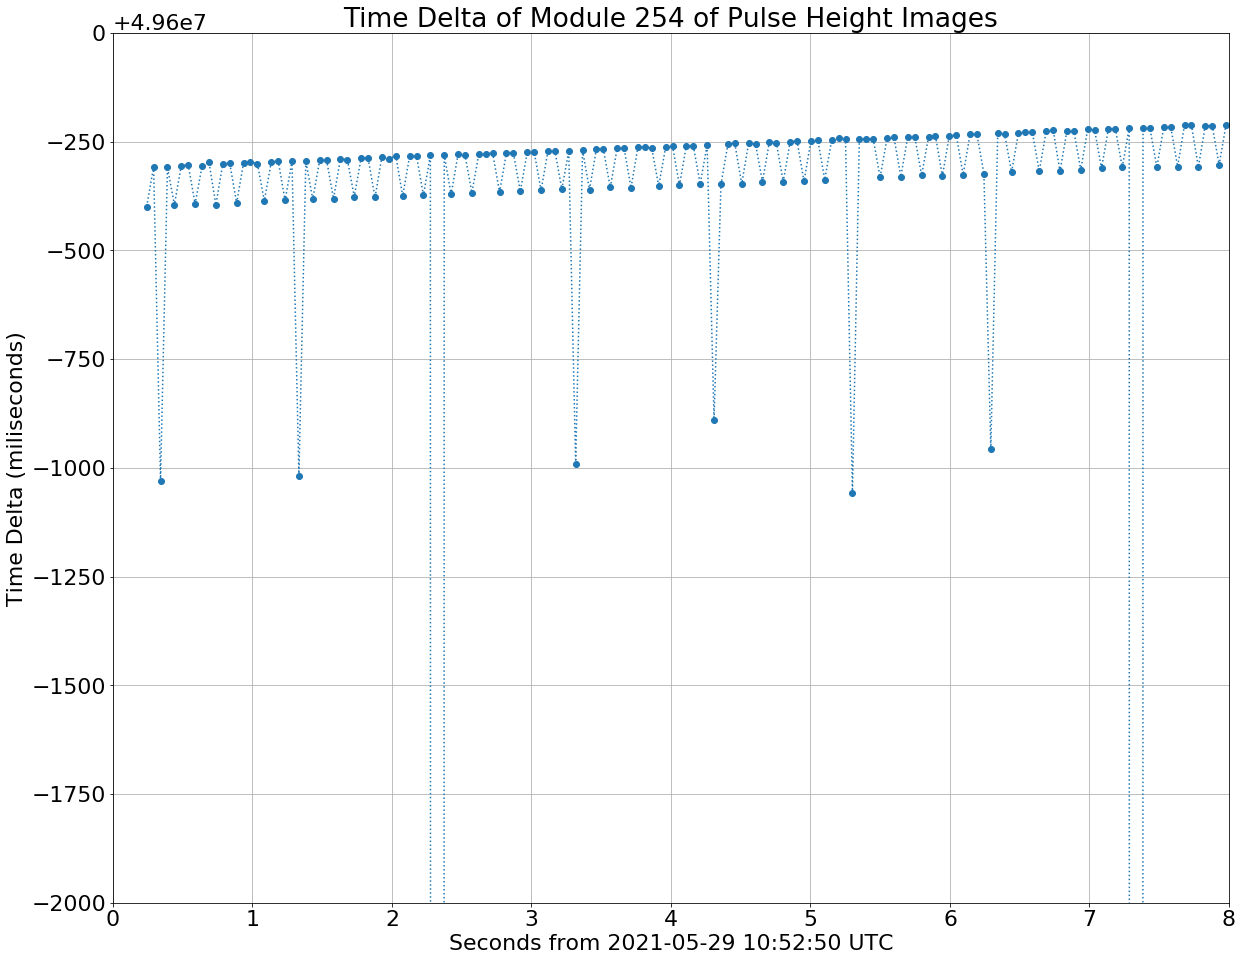

In [87]:
fig = plt.figure(figsize=(20,16))
plt.title("Time Delta of Module " + str(module_analysed) + " of Pulse Height Images")
plt.xlabel("Seconds from " + starting_time + " UTC")#"Frame Number")
plt.ylabel("Time Delta (miliseconds)")
plt.plot(image_times[:-1]*1e-9, np.array(image_dt), marker= "o", linestyle=":")
plt.grid()
plt.ylim(49598000, 49600000)#49.598, 49.600)#0.04945, 0.04965)
plt.xlim(0, 8)
plt.show()
fig.savefig(str(module_analysed) + "_dt_graph.png")

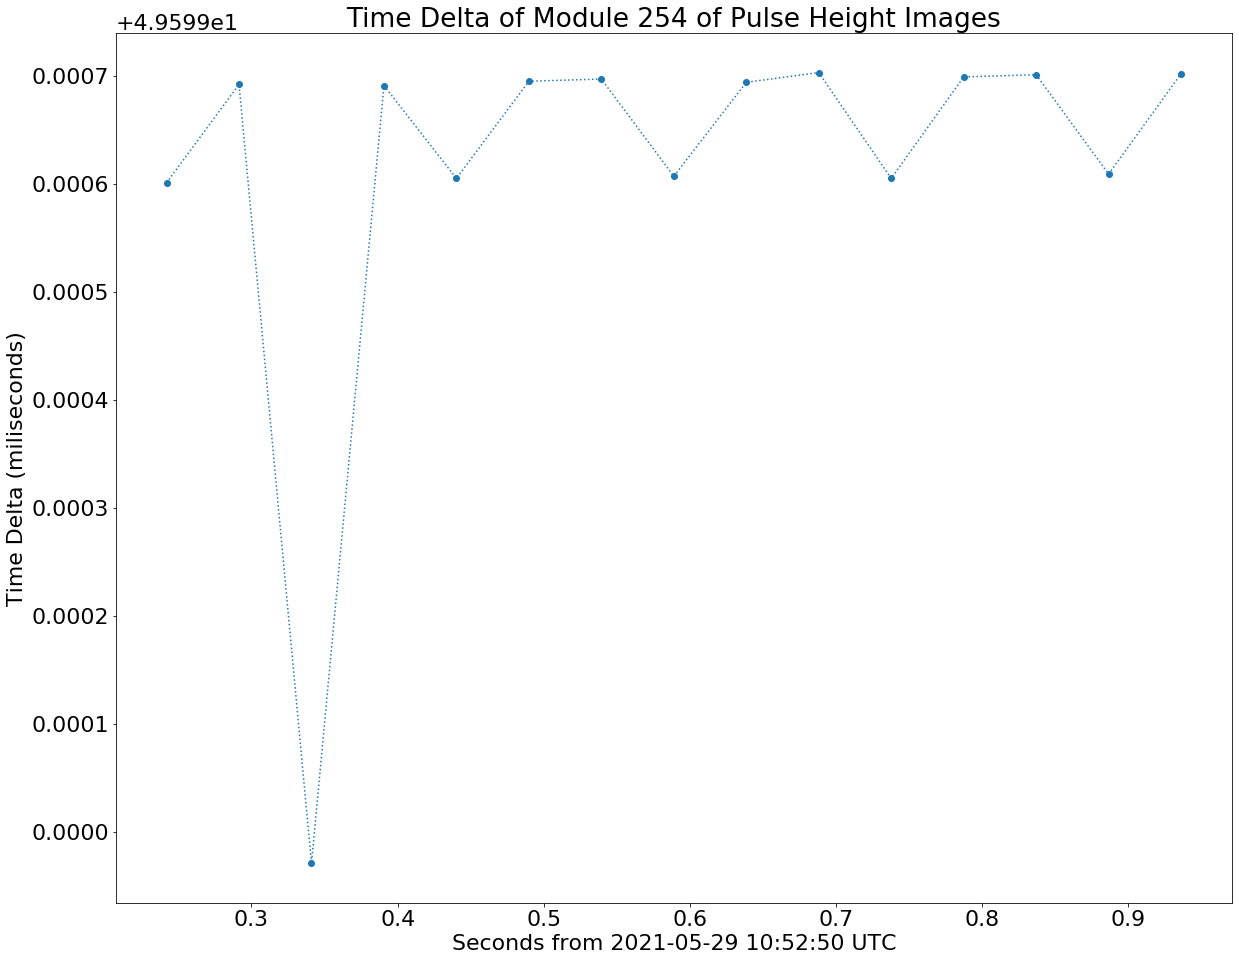

Time	  Time Delta
241880293 49.599601
291479894 49.599692
341079586 49.598971
390678557 49.599691
440278248 49.599605
489877853 49.599695
539477548 49.599697
589077245 49.599607
638676852 49.599694
688276546 49.599703
737876249 49.599605
787475854 49.599699
837075553 49.599700999999996
886675254 49.599609
936274863 49.599702


In [285]:
fig = plt.figure(figsize=(20,16))
plt.title("Time Delta of Module " + str(module_analysed) + " of Pulse Height Images")
plt.xlabel("Seconds from " + starting_time + " UTC")#"Frame Number")
plt.ylabel("Time Delta (miliseconds)")
plt.plot(np.array(image_times[:-1])[:15]*1e-9, np.array(image_dt)[:15]*1e-6, marker= "o", linestyle=":")
plt.show()
fig.savefig(str(module_analysed) + "_dt_graph_zoomed.png")

In [259]:
mod1imageTime = image_times
mod1image_dt = image_dt

In [270]:
mod254imageTime = image_times
mod254image_dt = image_dt

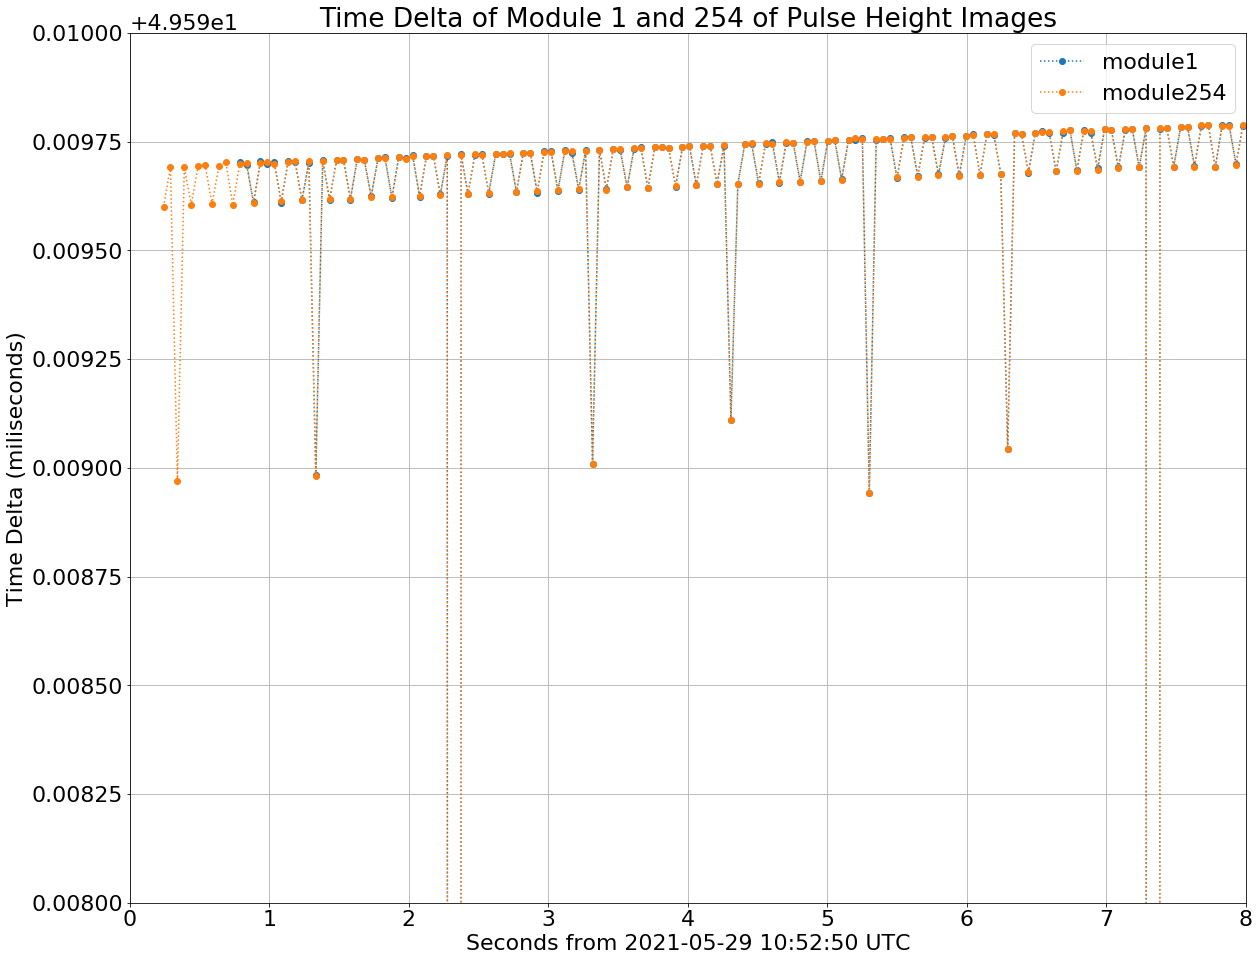

In [310]:
fig = plt.figure(figsize=(20,16))
plt.title("Time Delta of Module 1 and 254 of Pulse Height Images")
plt.xlabel("Seconds from " + starting_time + " UTC")#"Frame Number")
plt.ylabel("Time Delta (miliseconds)")
plt.plot(mod1imageTime[:-1]*1e-9, np.array(mod1image_dt)*1e-6, marker= "o", linestyle=":", label="module1")
plt.plot(mod254imageTime[:-1]*1e-9, np.array(mod254image_dt)*1e-6, marker= "o", linestyle=":", label="module254")
plt.grid()
plt.ylim(49.598, 49.600)#0.04945, 0.04965)
plt.xlim(0, 8)
plt.legend()
plt.show()
fig.savefig("1_254_dt_graph.png")

In [44]:
print(type(np.array(mod1image_dt)*1e-6))

NameError: name 'mod1image_dt' is not defined

In [312]:
print("Module 1")
print("Time\t", "   Time Delta")
for time, value in zip(mod1imageTime[:-1][:15]*1e-9, np.array(mod1image_dt)[:15]*1e-6):
    print("{0:0.9f} {1:0.6f}".format(time, value))
print("\n")
print("Module 254")
print("Time\t", "   Time Delta")
for time, value in zip(mod254imageTime[:-1][:50]*1e-9, np.array(mod254image_dt)[:50]*1e-6):
    print("{0:0.9f} {1:0.6f}".format(time, value))

Module 1
Time	    Time Delta
0.787475856 49.599703
0.837075559 49.599697
0.886675256 49.599611
0.936274867 49.599705
0.985874572 49.599699
1.035474271 49.599704
1.085073975 49.599610
1.134673585 49.599705
1.184273290 49.599704
1.233872994 49.599616
1.283472610 49.599702
1.333072312 49.598984
1.382671296 49.599707
1.432271003 49.599617
1.481870620 49.599707


Module 254
Time	    Time Delta
0.241880293 49.599601
0.291479894 49.599692
0.341079586 49.598971
0.390678557 49.599691
0.440278248 49.599605
0.489877853 49.599695
0.539477548 49.599697
0.589077245 49.599607
0.638676852 49.599694
0.688276546 49.599703
0.737876249 49.599605
0.787475854 49.599699
0.837075553 49.599701
0.886675254 49.599609
0.936274863 49.599702
0.985874565 49.599703
1.035474268 49.599700
1.085073968 49.599614
1.134673582 49.599703
1.184273285 49.599706
1.233872991 49.599615
1.283472606 49.599705
1.333072311 49.598982
1.382671293 49.599706
1.432270999 49.599618
1.481870617 49.599707
1.531470324 49.599708
1.581070032 49

In [89]:
outliers = []
for i in range(len(image_dt)):
    if image_dt[i] < 3e7 or image_dt[i] > 5e7:
        outliers.append([i, image_dt[i], images[i][1], images[i+1][1]])

In [90]:
print(len(outliers))

7


In [91]:
print(np.array(outliers)[:,0])

[162 182 210 216 220 221 225]


In [92]:
print(np.array(outliers)[:,1]/1e9)

[1e-09 0.148798689 0.099199646 0.247999055 0.148799416 0.198399252
 0.446397674]


index  162
dt (seconds) 1e-09


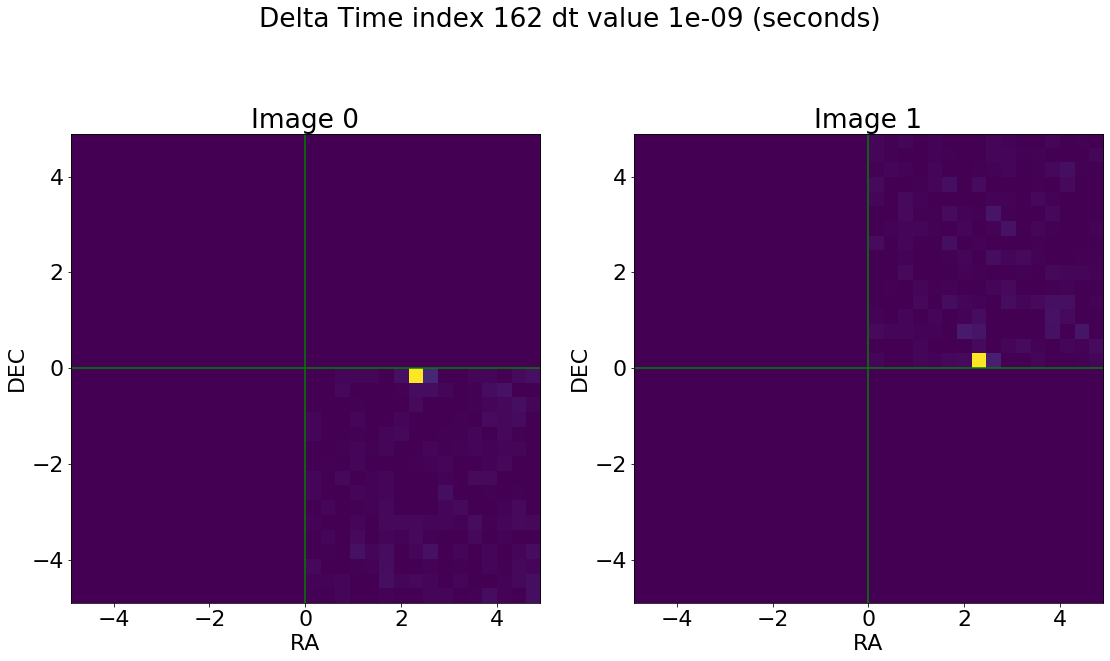

index  182
dt (seconds) 0.148798689


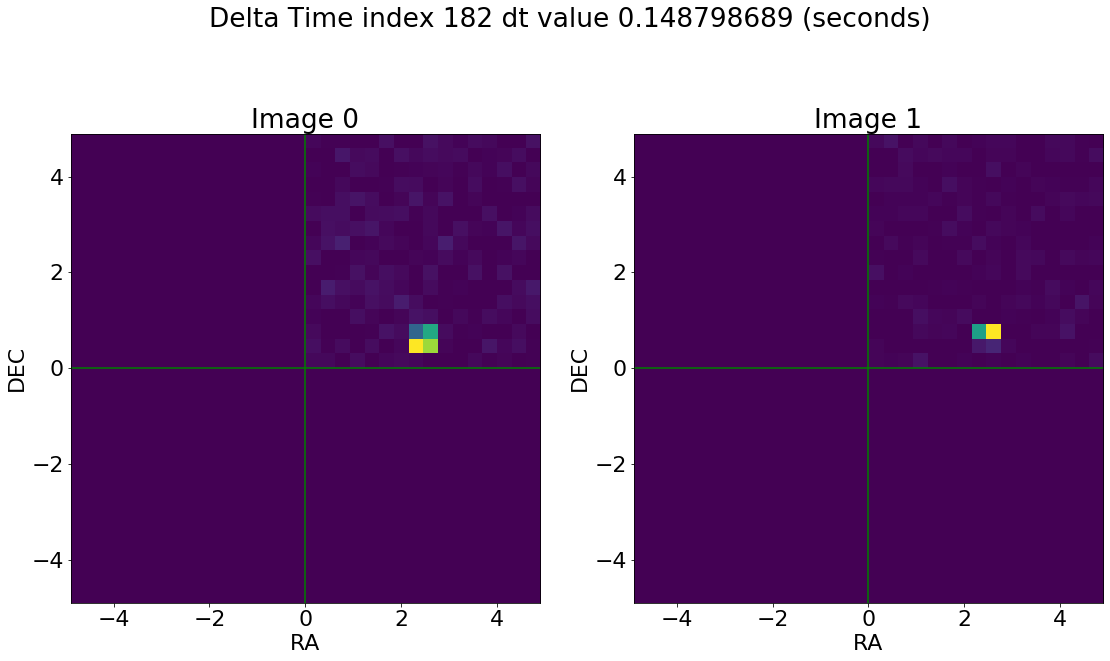

index  210
dt (seconds) 0.099199646


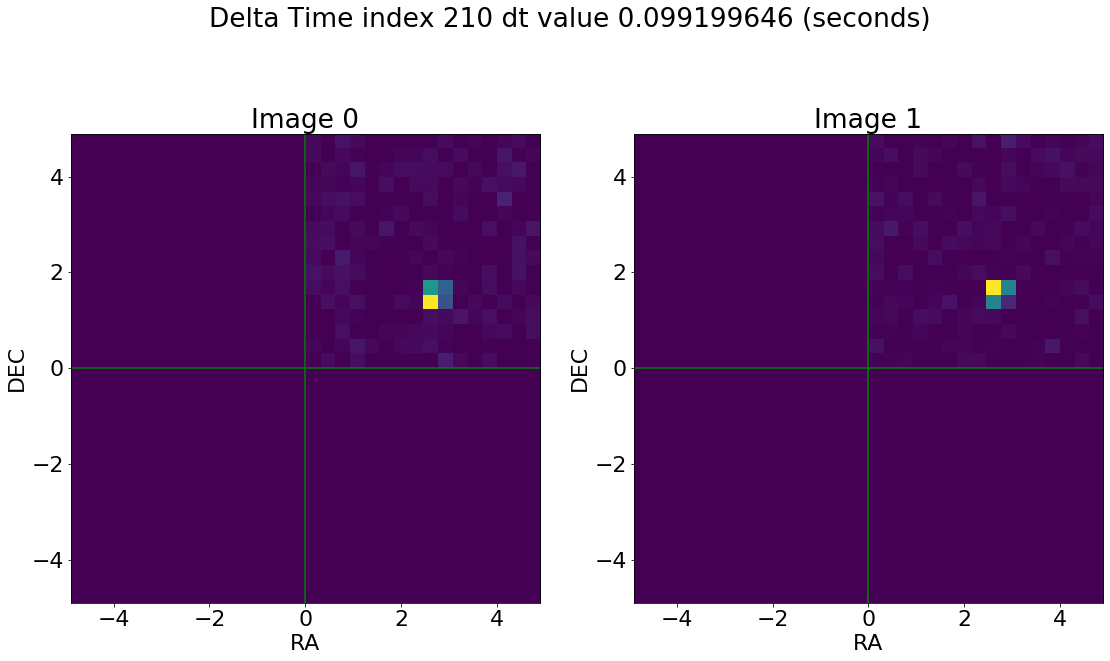

index  216
dt (seconds) 0.247999055


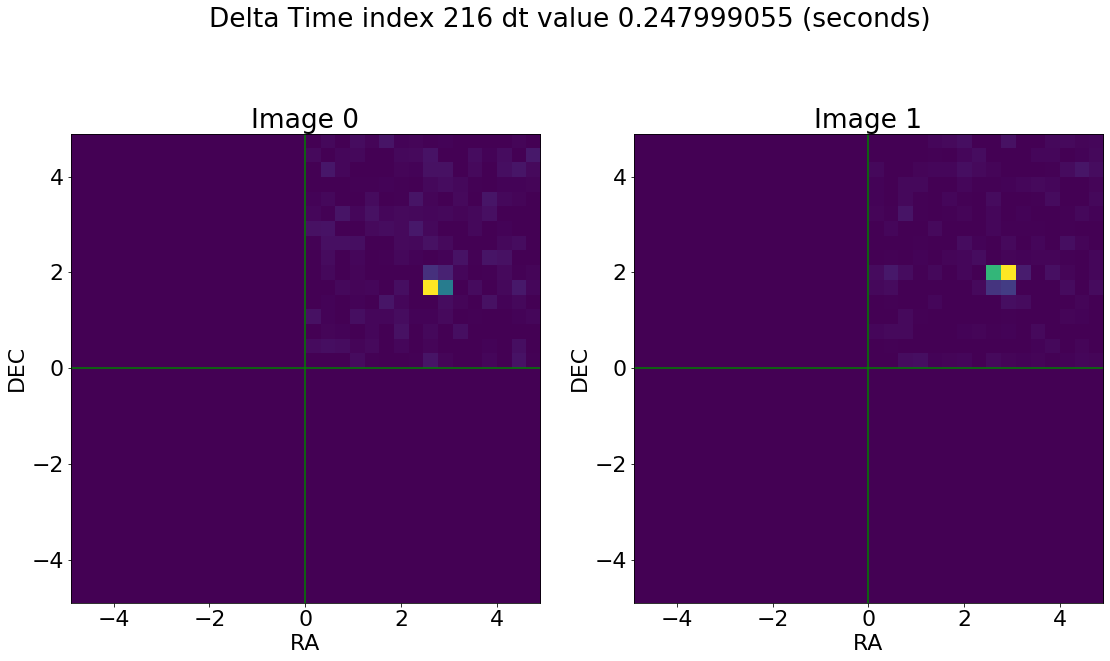

index  220
dt (seconds) 0.148799416


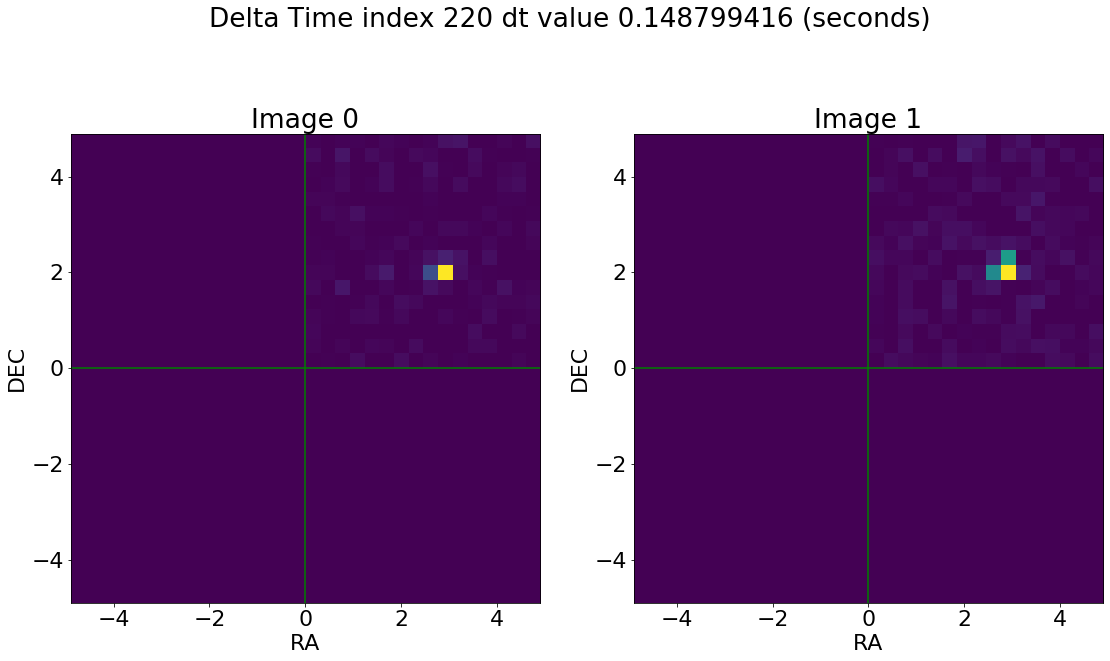

index  221
dt (seconds) 0.198399252


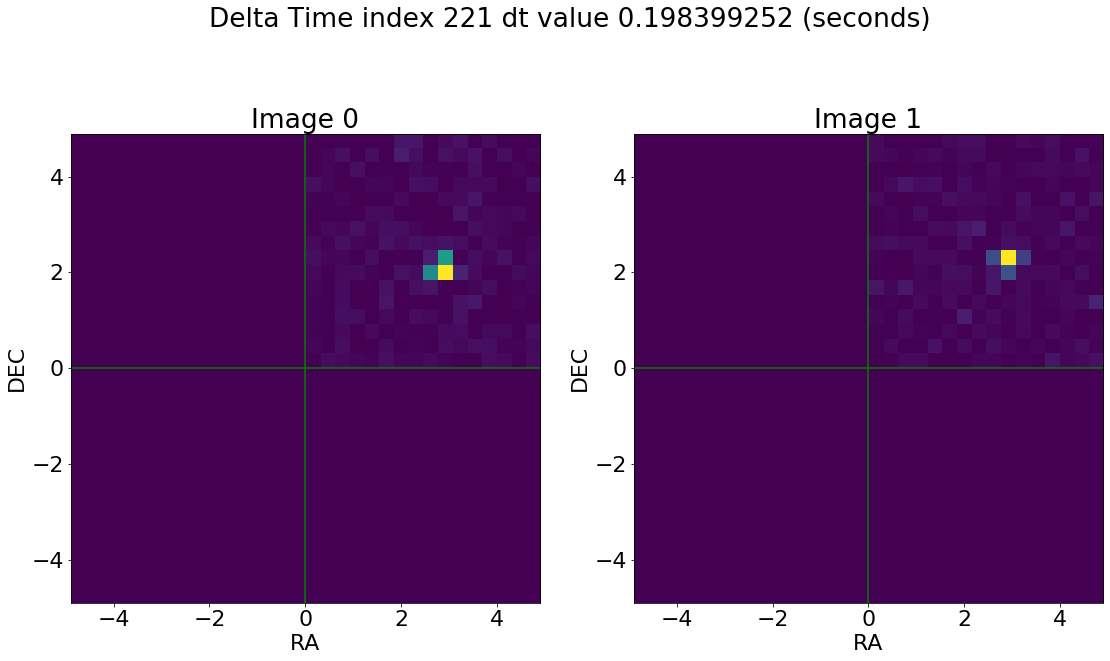

index  225
dt (seconds) 0.446397674


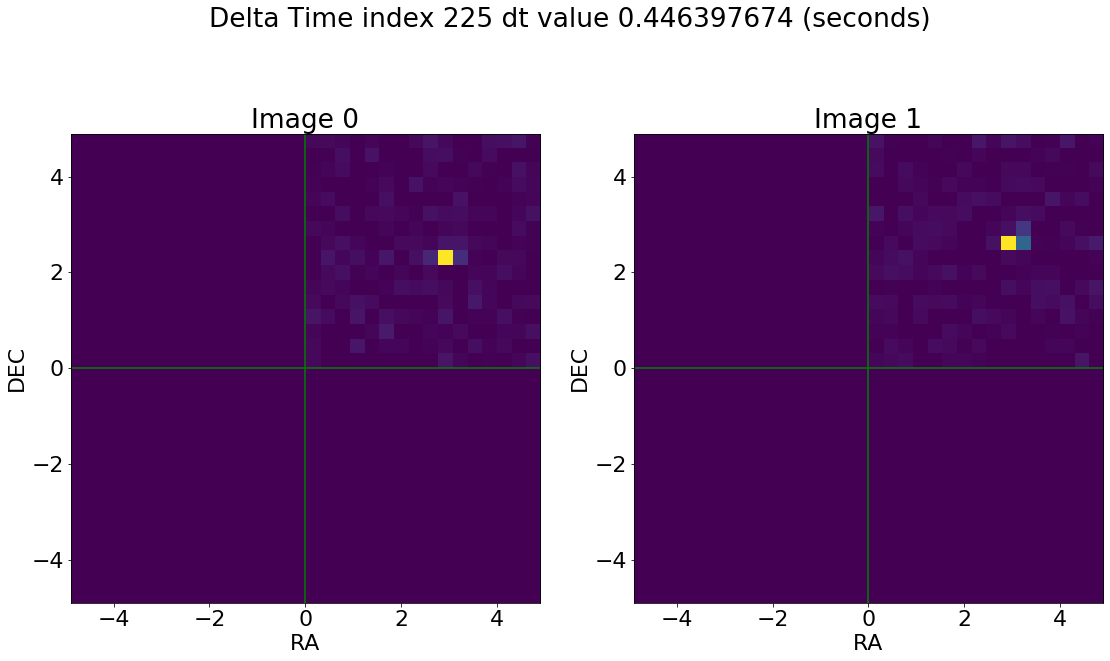

In [93]:
for img in outliers:
    print("index ", img[0])
    print("dt (seconds)", img[1]/1e9)
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(18.5, 10.5)
    fig.suptitle("Delta Time index " + str(img[0]) + " dt value " + str(img[1]/1e9) + " (seconds)")
    for i in range(2):
        axs[i].set_title("Image " + str(i))
        axs[i].axvline(x=0, color="green")
        axs[i].axhline(y=0, color="green")
        axs[i].set_xlabel("RA")
        axs[i].set_ylabel("DEC")
        ims = axs[i].imshow(img[i+2], extent=graph_extent)
        #fig.colorbar(ims, ax=[i])
    
    plt.show()
    fig.savefig(str(module_analysed) + "_outliner_ind" + str(img[0]) + ".png")

In [313]:
new_file = h5py.File("Images.h5", "w")

In [314]:
new_PHData = new_file.create_group("PHData")

In [315]:
new_modPair = new_PHData.create_group("ModulePair_00254_00001")

In [403]:
new_headers = np.array([])
new_images = np.array([])
for key in file_frames:
    fHeaders = np.array(file_frames[key])[:,0]
    fImages = np.array(file_frames[key])[:,1]
    headers = np.zeros((len(fHeaders), len(PHData_fields)), dtype=int)
    images = np.zeros((len(fImages), 16*16), dtype=int)
    for index in range(len(fHeaders)):
        headers[index] = np.array(fHeaders[index])
    for index in range(len(fImages)):
        images[index] = np.array(fImages[index])
    if len(new_headers) == 0:
        new_headers = headers
        new_images = images
    else:
        new_headers = np.append(new_headers, headers, axis=0)
        new_images = np.append(new_images, images, axis=0)
        
for i in range(len(PHData_fields)):
    arr = np.zeros((5000,1,1), dtype=int)
    arr[:len(new_headers),0,0] = new_headers[:,i]
    new_modPair.create_dataset(PHData_format.format(0)+"_"+PHData_fields[i], data=arr)
arr = np.zeros((5000,1,16*16), dtype=int)
arr[:len(new_images),0,:] = new_images[:]
new_modPair.create_dataset(PHData_format.format(0), data=arr)

<HDF5 dataset "DATA000000000": shape (5000, 1, 256), type "<i8">

In [404]:
new_file.close()

In [328]:
test = np.zeros((3,3))

In [333]:
test[:,2] = [1,1,1]

In [334]:
print(test)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [ ]:
for key in file:
    print(key)